# Fake news project 

#### Supervised by Zuhaira Muhammad Zain 

#### Created by Students Name Students ID

#### Monerah Almobarak 442002988

#### Nada Alotaibi 442003374

#### Sarah Altaweel 442000786

#### Sarah Aljuhani 442005104

In [1]:
# Import the necessary libraries
import warnings
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Ignore warnings
warnings.filterwarnings("ignore")

In [3]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\moner\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\moner\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\moner\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Read the data
data = pd.read_csv("datamlproject.csv")

# explanatory of your data

In [5]:
# looking the head DataSet
data.head()

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,31-Dec-17,1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,31-Dec-17,1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,30-Dec-17,1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,29-Dec-17,1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,25-Dec-17,1


In [6]:
# looking the shape DataSet
data.shape

(10000, 5)

In [7]:
#Checking the dtypes of all the columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    10000 non-null  object
 1   text     10000 non-null  object
 2   subject  10000 non-null  object
 3   date     10000 non-null  object
 4   class    10000 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 390.8+ KB


### Class Distribution Bar Chart:
- Create a bar chart showing the distribution of fake and not fake news articles.

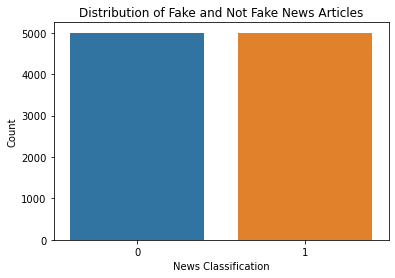

In [8]:
sns.countplot(x='class', data=data)
plt.xlabel('News Classification')
plt.ylabel('Count')
plt.title('Distribution of Fake and Not Fake News Articles')
plt.show()

- the Class Distribution Bar Char show balanced distribution so the data is in good quality.


### Word Clouds: 
- Generate word clouds for both fake and not fake news articles to visualize the most common words in each class.

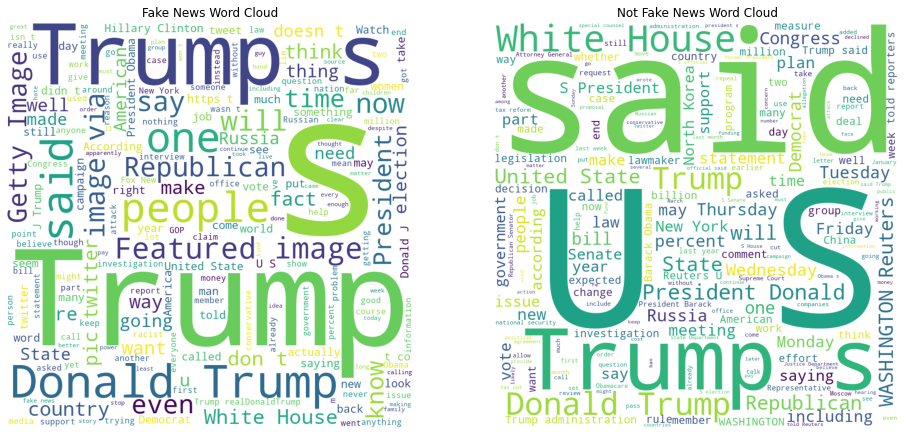

In [9]:
from wordcloud import WordCloud

# Create separate dataframes for fake and not fake news articles
fake_news = data[data['class'] == 1]
not_fake_news = data[data['class'] == 0]

# Generate word clouds for both classes
fake_wordcloud = WordCloud(width=800, height=800, background_color='white').generate(' '.join(fake_news['text']))
not_fake_wordcloud = WordCloud(width=800, height=800, background_color='white').generate(' '.join(not_fake_news['text']))

# Plot word clouds
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(fake_wordcloud)
ax1.set_title('Fake News Word Cloud')
ax1.axis('off')
ax2.imshow(not_fake_wordcloud)
ax2.set_title('Not Fake News Word Cloud')
ax2.axis('off')
plt.show()

## Data preprocessing


In [10]:
# count the number of missing values in each column
data.isnull().sum()

title      0
text       0
subject    0
date       0
class      0
dtype: int64

### Missing Values Heatmap: 
- Use a heatmap to visualize the presence of missing values in the dataset.

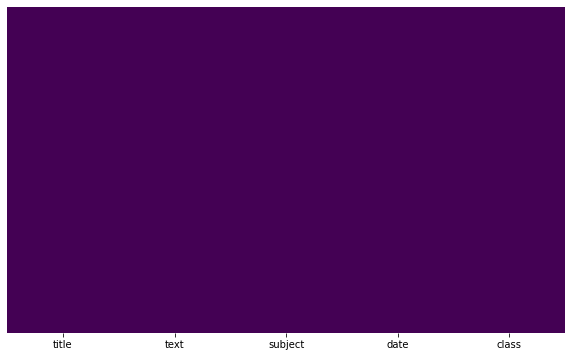

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.show()

- it clean heatmap with no bright spots indicates that there are no missing values, so the data is in good quality.
 

###  there are no missing values in each rows in the DataFrame


In [12]:
# Check for duplicates in rows
duplicate_rows = data.duplicated()

# Count the total number of duplicates
total_duplicates = duplicate_rows.sum()

# Print the total number of duplicates
print(f"Total duplicates: {total_duplicates}")

Total duplicates: 36


In [13]:
# Remove duplicates from the DataFrame
data = data.drop_duplicates()

# Verify the removal of duplicates
print("DataFrame shape after removing duplicates:", data.shape)

DataFrame shape after removing duplicates: (9964, 5)


In [14]:
data.shape

(9964, 5)

### there are some duplicates values and we remove it to improve quality

In [15]:
# Combine the text columns
data['combined'] = data['title'] + ' ' + data['text'] + ' ' + data['subject'] + ' ' + data['date'] 

In [16]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        self.stopwords = set(stopwords.words('english'))
        self.sid = SentimentIntensityAnalyzer()

    def __call__(self, doc):
        tokens = word_tokenize(doc)  # Tokenization using NLTK's word_tokenize function
        tokens = [self.wnl.lemmatize(t) for t in tokens]  # Lemmatization
        tokens = [t for t in tokens if t.lower() not in self.stopwords]  # Stop word removal

        # Sentiment analysis
        sent_scores = self.sid.polarity_scores(doc)
        tokens.extend(["sent_{}".format(k) for k, v in sent_scores.items() if v != 0])

        return tokens

class TextPreprocessor:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        self.stopwords = set(stopwords.words('english'))
        self.sid = SentimentIntensityAnalyzer()
        self.lda = LatentDirichletAllocation(n_components=5, random_state=42)

    def preprocess(self, doc):
        # Tokenization and Lemmatization
        tokens = word_tokenize(doc)
        tokens = [self.wnl.lemmatize(t) for t in tokens]

        # Stop word removal
        tokens = [t for t in tokens if t.lower() not in self.stopwords]

        # Sentiment analysis
        sent_scores = self.sid.polarity_scores(doc)
        tokens.extend(["sent_{}".format(k) for k, v in sent_scores.items() if v != 0])

        return ' '.join(tokens)

# Apply the preprocessing on the combined text
preprocessor = TextPreprocessor()
data['preprocessed'] = data['combined'].apply(preprocessor.preprocess)

- Tokenization: Breaking text into individual words or phrases, called tokens. This is usually the first step in any NLP task.
 
- Lemmatization: Reducing words to their base form, such as converting "running" to "run".
 
- Stop word removal: Removing common words that don't carry much meaning, such as "the", "and", and "of".

- Sentiment analysis: Determining the sentiment or emotional tone of the text, such as positive, negative, or neutral.

- Part-of-speech (POS) tagging: Identifying the part of speech of each word in the text, such as noun, verb, adjective, etc.

- Named entity recognition (NER): Identifying and classifying named entities in the text, such as people, organizations, and locations.

- Topic modeling: Discovering the underlying topics in the text, which can be useful for organizing and summarizing large amounts of text

In [17]:
# data after preprocess
data

,title,text,subject,date,class,combined,preprocessed
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,31-Dec-17,1,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump Sends Embarrassing New Year ’ Eve...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,31-Dec-17,1,Drunk Bragging Trump Staffer Started Russian ...,Drunk Bragging Trump Staffer Started Russian C...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,30-Dec-17,1,Sheriff David Clarke Becomes An Internet Joke...,Sheriff David Clarke Becomes Internet Joke Thr...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,29-Dec-17,1,Trump Is So Obsessed He Even Has Obama’s Name...,Trump Obsessed Even Obama ’ Name Coded Website...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,25-Dec-17,1,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis Called Donald Trump Christmas Spe...
...,...,...,...,...,...,...,...
9994,U.S. Agriculture secretary nominee submits eth...,(Reuters) - U.S. President Donald Trump’s nomi...,politicsNews,13-Mar-17,0,U.S. Agriculture secretary nominee submits eth...,U.S. Agriculture secretary nominee submits eth...
9995,Trump aides attack agency that will analyze he...,WASHINGTON (Reuters) - Aides to U.S. President...,politicsNews,12-Mar-17,0,Trump aides attack agency that will analyze he...,Trump aide attack agency analyze health bill '...
9996,Highlights: The Trump presidency on March 12 a...,(Reuters) - Highlights of the day for U.S. Pre...,politicsNews,12-Mar-17,0,Highlights: The Trump presidency on March 12 a...,Highlights : Trump presidency March 12 8:42 p....
9997,Obama lawyers move fast to join fight against ...,WASHINGTON (Reuters) - When Johnathan Smith re...,politicsNews,13-Mar-17,0,Obama lawyers move fast to join fight against ...,Obama lawyer move fast join fight Trump WASHIN...


In [18]:
# Split the data into features and target
X = data['preprocessed']
y = data['class']

In [19]:
# Initialize the vectorizer and scaler
vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer())
standard_scaler = StandardScaler(with_mean=False)

# Transform the features using the vectorizer and scaler
X_tfidf = vectorizer.fit_transform(X)
X_scaled = standard_scaler.fit_transform(X_tfidf)   

In [20]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.40, random_state=42)

In [21]:
# Initialize models
svm_model = SVC()
lr_model = LogisticRegression()
nb_model = GaussianNB()

# First model is SVM model

In [22]:
# Train and evaluate SVM model with cross-validation
svm_cv_scores = cross_val_score(svm_model, X_train, y_train, cv=5)
print(f"SVM CV scores: {svm_cv_scores}")
print(f"SVM CV scores mean: {svm_cv_scores.mean()}")

# Train the SVM model on the entire training set
svm_model.fit(X_train, y_train)

# Make predictions on the test set
svm_y_pred = svm_model.predict(X_test)
svm_y_pred

SVM CV scores: [0.92140468 0.92725753 0.90551839 0.90460251 0.92887029]
SVM CV scores mean: 0.9175306810707939


array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [23]:
#Printing the training and testing accuracies
print('Training Accuracy : {:.3f}'.format(svm_model.score(X_train, y_train)))
print('Test Accuracy : {:.3f}'.format(svm_model.score(X_test, y_test)))

Training Accuracy : 0.996
Test Accuracy : 0.924


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      1920
           1       0.88      0.98      0.93      2066

    accuracy                           0.92      3986
   macro avg       0.93      0.92      0.92      3986
weighted avg       0.93      0.92      0.92      3986



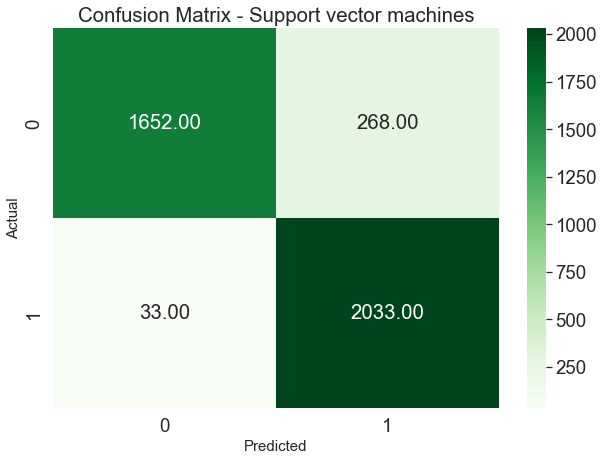

In [24]:
# Compute the classification report for SVM
svm_report = classification_report(y_test, svm_y_pred)
print("SVM Classification Report:")
print(svm_report)

# Compute the confusion matrix for SVM
svm_cm = confusion_matrix(y_test, svm_y_pred)

sns.set(font_scale=1.7)
plt.figure(figsize=(10,7))
sns.heatmap(svm_cm, annot=True, cmap="Greens", fmt='.2f')

plt.title('Confusion Matrix - Support vector machines')
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Actual", fontsize=15)
plt.show()

It turned out that in SVC Confusion Matrix:
- TP = 2033, so that the model predicted the right news correctly predicted as the actual right news
- TN = 1652, so that the model predicted fake news correctly predicted as an actual fake news 
- FP = 268, so that the model predicted the right news incorrectly predicted the actual right news. This is considered a type     1 error
- FN = 33, so that the model predicted the fake news incorrectly predicted the actual fake news. This is considered a type 
  2 error

# Second model is Gaussian Naive Bayes

In [25]:
# Train and evaluate Gaussian Naive Bayes model with cross-validation
nb_cv_scores = cross_val_score(nb_model, X_train.toarray(), y_train, cv=5)
print(f"Gaussian Naive Bayes CV scores: {nb_cv_scores}")
print(f"Gaussian Naive Bayes CV scores mean: {nb_cv_scores.mean()}")

# Train the Gaussian Naive Bayes model on the entire training set
nb_model.fit(X_train.toarray(), y_train)

# Make predictions on the test set
nb_y_pred = nb_model.predict(X_test.toarray())
nb_y_pred

Gaussian Naive Bayes CV scores: [0.8729097  0.88963211 0.88043478 0.88619247 0.88953975]
Gaussian Naive Bayes CV scores mean: 0.8837417612403968


array([0, 1, 0, ..., 1, 0, 0], dtype=int64)

In [26]:
#Printing the training and testing accuracies
print('Training Accuracy : {:.3f}'.format(nb_model.score(X_train.toarray(), y_train)))
print('Test Accuracy : {:.3f}'.format(nb_model.score(X_test.toarray(), y_test))) 

Training Accuracy : 1.000
Test Accuracy : 0.893


Gaussian Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1920
           1       0.87      0.93      0.90      2066

    accuracy                           0.89      3986
   macro avg       0.90      0.89      0.89      3986
weighted avg       0.89      0.89      0.89      3986



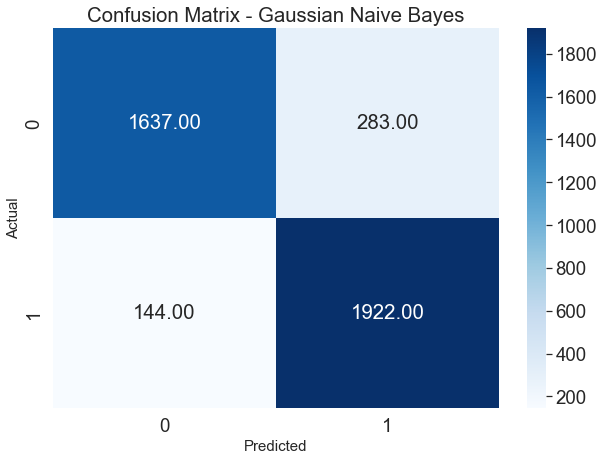

In [27]:
# Compute the classification report for Gaussian Naive Bayes
nb_report = classification_report(y_test, nb_y_pred)
print("Gaussian Naive Bayes Classification Report:")
print(nb_report)

import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

nb_cm = confusion_matrix(y_test, nb_y_pred)

sns.set(font_scale=1.7)
plt.figure(figsize=(10,7))
sns.heatmap(nb_cm, annot=True, cmap="Blues", fmt='.2f')

plt.title('Confusion Matrix - Gaussian Naive Bayes')
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Actual", fontsize=15)
plt.show()

It turned out that in Gaussian Naive Bayes Confusion Matrix:
- TP = 1922, so that the model predicted the right news correctly predicted as the actual right news
- TN = 1637, so that the model predicted fake news correctly predicted as an actual fake news 
- FP = 283, so that the model predicted the right news incorrectly predicted the actual right news. This is considered a type     1 error
- FN = 144, so the model predicted the fake news incorrectly predicted the actual fake news. This is considered a type 
  2 error

# Third model is Logistic Regression model

In [28]:
# Train and evaluate Logistic Regression model with cross-validation
lr_cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5)
print(f"Logistic Regression CV scores: {lr_cv_scores}")
print(f"Logistic Regression CV scores mean: {lr_cv_scores.mean()}")

# Train the Logistic Regression model on the entire training set
lr_model.fit(X_train, y_train)

# Make predictions on the test set
lr_y_pred = lr_model.predict(X_test)
lr_y_pred

Logistic Regression CV scores: [0.97826087 0.98913043 0.99080268 0.97656904 0.98242678]
Logistic Regression CV scores mean: 0.9834379591665383


array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [29]:
#Printing the training and testing accuracies
print('Training Accuracy : {:.3f}'.format(lr_model.score(X_train, y_train)))
print('Test Accuracy : {:.3f}'.format(lr_model.score(X_test, y_test))) 

Training Accuracy : 1.000
Test Accuracy : 0.985


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1920
           1       1.00      0.97      0.99      2066

    accuracy                           0.99      3986
   macro avg       0.99      0.99      0.99      3986
weighted avg       0.99      0.99      0.99      3986



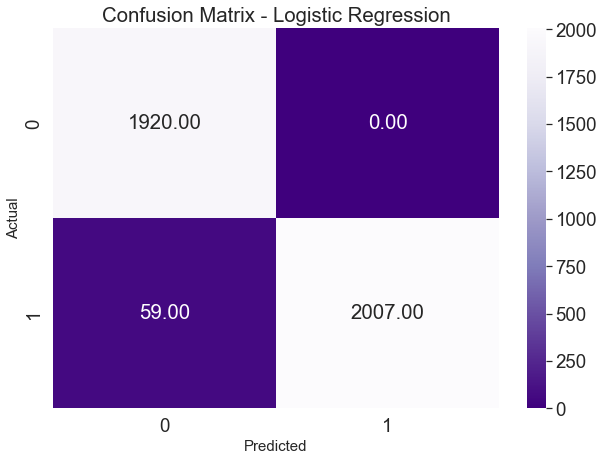

In [30]:
# Compute the classification report for Logistic Regression
lr_report = classification_report(y_test, lr_y_pred)
print("Logistic Regression Classification Report:")
print(lr_report)

# Compute the confusion matrix for Logistic Regression
lr_cm = confusion_matrix(y_test, lr_y_pred)

sns.set(font_scale=1.7)
plt.figure(figsize=(10,7))
sns.heatmap(lr_cm, annot=True, cmap="Purples_r", fmt='.2f')

plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Actual", fontsize=15)
plt.show()

It turned out that in Logistic Regression Confusion Matrix:
- TP = 2007, so that the model predicted the right news correctly predicted as the actual right news
- TN = 1920, so that the model predicted fake news correctly predicted as an actual fake news 
- FP = 0, so the model didn't predict any right news incorrectly predicted the actual right news. This is considered a type        1 error
- FN = 59, so that the model predicted the fake news incorrectly predicted the actual fake news. This is considered a type 
  2 error